# 6CCS3EEP: Applications of Deep Learning in Resource Allocation in Wireless Networks

### This notebook contains the code and the results of training and testing the DNN for BS = 3, K = 6 scenario.

### Author: Stanislav Chistyakov, 3rd Year Electronic Engineering with Management, 1720783

## Table of Contents:

[Part 1: Setup](#part_1)

[Part 2: Training](#part_2) <br>
    [Part 2.1: Training with 50 000 samples](#50k) <br>
    [Part 2.2: Training with 100 000 samples](#100k) <br>
    [Part 2.3: Training with 200 000 samples](#200k) <br>
    [Part 2.4: Training with 500 000 samples](#500k) <br>
    
[Part 3: Testing](#part_3) <br>
    [Part 3.1: Testing R = 100, r = {20,50,99}](#r) <br>
    [Part 3.2: Testing R = {200,300,500}, r = 0](#R) <br>

## <a id='part_1'>Part 1: Setup</a>

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

### Code below is used for the faster training on Amazon Web Services EC2 Instance with a GPU

In [3]:
torch.cuda.set_device(0)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Create the model class:

#### Parameters:

1. input_size: the number of neurons in the input layer (i.e. the number of direct and interference channels);
2. hidden_size: the number of hidden neurons used in three hidden layers;
3. output size: the number of neurons in the output layer (i.e. the number of direct channels);
4. activ: the activation function used in each of the layers (except for the last one, where max(0,1) is used to ensure that the power constraint is satisfied);
5. inp_drop_prob: the probability of the input neurons to be dropped during training;
6. hid_drop_prob: the probability of the hidden neurons to be dropped during training;
7. weights_init_flag: boolean variable that identifies if the weight initialisation is altered from the default PyTorch setting;
8. weights_init: if weights_init_flag is True, the weight initialisation that will be used for the layers.

In [4]:
def initiate_model(input_size,hidden_size,output_size,inp_drop_prob,hid_drop_prob,activ,weights_init_flag,
                  weights_init):
    
    class NN(nn.Module):
        def __init__(self):

            super(NN,self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.dp1 = nn.Dropout(inp_drop_prob)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.dp2 = nn.Dropout(hid_drop_prob)
            self.fc3 = nn.Linear(hidden_size, hidden_size)
            self.dp3 = nn.Dropout(hid_drop_prob)
            self.fc4 = nn.Linear(hidden_size, output_size)
            
                        
            if weights_init_flag:
                weights_init(self.fc1.weight)
                weights_init(self.fc2.weight)
                weights_init(self.fc3.weight)
                weights_init(self.fc4.weight)

        def forward(self, x):
            x = self.fc1(x)
            x = activ(x)
            x = self.dp1(x)
            x = self.fc2(x)
            x = activ(x)
            x = self.dp2(x)
            x = self.fc3(x)
            x = activ(x)
            x = self.dp3(x)
            x = self.fc4(x).clamp(min=0,max=1)
            return x
        
    model = NN().double()

    return model

### Training process (train_nn function)

#### Parameters:

1. model: the model class variable used for training;
2. criterion: the loss function used in training;
3. optimizer: the optimisation algorithm used in training;
4. train_c: the set of training channels;
5. train_l: the set of training labels (power allocations);
6. valid_c: the set of validation channels (not used in updating DNN parameters);
7. valid l: the set of validation labels;
8. tr_b_size: the size of the training batches;
9. v_b_size: the size of the validation batches;
10. epochs: the number of iterations that the entire training set passes through the network; 
11. print_every: identifies the period (number of training batches) with which the training and validation losses are outputted;
12. patience: the parameter used for setting early stopping;
13. lrs: the set of learning rates (used for Cyclical LR);
14. lr_flag: the boolean variable that identifies if the Cyclical LR are used in training.

In [5]:
def train_nn(model,criterion,optimizer,train_c,train_l,valid_c,valid_l,tr_b_size,v_b_size,epochs,print_every,patience,
            lrs,lr_flag):
    
    def train_batch_size(tr_b_size): #function generates training batches
        if train_c.shape[0] % tr_b_size == 0:
            training_batches = []
            labels_batches = []
            for i in range(0,int(train_c.shape[0]/tr_b_size)):
                training_batches.append(train_c[i*tr_b_size:i*tr_b_size+tr_b_size,:])
                labels_batches.append(train_l[i*tr_b_size:i*tr_b_size+tr_b_size,:])
        return training_batches,labels_batches

    def valid_batch_size(v_b_size): #function generates validation batches
        if valid_c.shape[0] % v_b_size == 0:
            v_c_batches = []
            v_l_batches = []
            for i in range(0,int(valid_c.shape[0]/v_b_size)):
                v_c_batches.append(valid_c[i*v_b_size:i*v_b_size+v_b_size,:])
                v_l_batches.append(valid_l[i*v_b_size:i*v_b_size+v_b_size,:])
        return v_c_batches,v_l_batches

    tr_c_batches, tr_l_batches = train_batch_size(tr_b_size) 
    v_c_batches, v_l_batches = valid_batch_size(v_b_size)
    
    def validation(model,v_c_batches,v_l_batches,criterion): #validation function
        v_loss = 0
        for i in range(0,len(v_l_batches)):
            output = model.forward(v_c_batches[i])
            v_loss += criterion(output,v_l_batches[i]).item()
        return v_loss

    #variables initiated 
    steps = 0
    tr_losses = [] #list with training losses recorded while training
    v_losses = [] #list with validation losses recorded while training
    stop_flag = False #boolean variable indicating early stopping
    start_time = time.time() #variable used for timing the training process
    lr_counter = 0 #counter used for assigning the corresponding learning rate (used when training with Cyclical LR)
    
    for e in range(epochs): #the training loop repeating for the overall number of epochs
        
        tr_loss = 0
        
        if len(v_losses) > 1: #this part of code checks if the current validation loss is the lowest and saves the 
            #model parameters if it is
            if v_losses[-1] <= np.asarray(v_losses).min():
                torch.save(model.state_dict(),'checkpoint_4.pth')
        
        if len(v_losses) > (patience*2): #early stopping condition
            if np.asarray(v_losses[-patience:]).mean() > np.asarray(v_losses[-(patience*2):-patience]).mean():
                stop_flag = True 
                break
                
        if lr_flag: 
            learn_rate = lrs[lr_counter]
            optimizer = torch.optim.AdamW(model.parameters(),lr=learn_rate,
                                         weight_decay=0.05,
                                         amsgrad=True)
            
        for i in range(0,len(tr_c_batches)):
            
            lr_counter +=1
            
            steps += 1
            
            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(tr_c_batches[i])
            loss = criterion(output, tr_l_batches[i])
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()

            if steps % print_every == 0:
                model.eval()

                print('Batches passed forward # - {}'.format(steps))

                with torch.no_grad():
                    v_loss = validation(model,v_c_batches,v_l_batches,criterion)

                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Training Loss: {:.4f}".format(tr_loss/print_every),
                      "Validation Loss: {:.4f}".format(v_loss/len(v_c_batches)))
                if lr_flag:
                    print("Current learning rate {:.5f}".format(learn_rate))
                tr_losses.append(tr_loss/print_every)
                v_losses.append(v_loss/len(v_c_batches))
                tr_loss = 0
                v_loss = 0

    end_time = time.time()
    
    best_valid_index = np.argmin(v_losses)
    best_valid = np.min(v_losses)
    print('The best model parameters reached after {} epochs, and the validation loss was {}'.format(best_valid_index+1,
                                                                                                    round(best_valid,4)))
    if stop_flag==True:
        print('The training was stopped after {} epochs'.format(len(v_losses)))
    
    plt.title('Training Loss vs Validation Loss')
    plt.ylabel('MSE')
    plt.xlabel('Number of epochs')
    plt.plot(tr_losses,'b',label='Training Loss')
    plt.plot(v_losses,'r',label='Validation Loss')
    plt.axvline(best_valid_index+1,color='y',label='Lowest Validation Error')
    plt.legend(loc="upper right")
    plt.show()

    print('Training time - {} seconds'.format(round(end_time-start_time,4)))
    
    model.load_state_dict(torch.load('checkpoint_4.pth'))
    model.eval()

    return (model, v_losses)

### Testing process

#### Procedure:

1. complete_test: 

    1.1. Parameters:
        1.1.1. output_size: the number of neurons in the output layer
        1.1.2. test_size: the size of the testing set
        1.1.3. model: the model being tested
        1.1.4. test_c: testing channels
        1.1.5. test_l: testing labels
        1.1.6. test_H: testing channel realisations matrix
        1.1.7. binarised_flag: the boolean variable that identifies if the labels and predictions should be binarised
        
    1.2. What does it do? -> The function receives the model as its input and the testing data before sending it further to send_to_test. After the testing was completed, complete_test function prints out the distribution of calculated sum-rates as a histogram.
    
2. send_to_test:

    2.1. Parameters:
        2.1.1. num_in_batch: counter used for iteratively sending testing samples (by default: 1)
        2.1.2. test_channels: testing channels
        2.1.3. test_labels: testing labels
        2.1.4. test_H: testing channel realisations matrix
        2.1.5. model: the model being tested
        2.1.6. output_size: the number of neurons in the output layer
        2.1.7. binarised_flag: the boolean variable that identifies if the labels and predictions should be binarised
        
    2.2. What does it do? -> The function sends training samples iteratively to calculate_sum_rate function by taking num_in_batch number of rows from test_channels, test_labels, test_H. The returned results are appended to two lists: predicted sum-rates and true sum-rates.
    
3. calculate_sum_rate:

    3.1. Parameters:
        3.1.1. model: the model being tested
        3.1.2. test_channels: testing channels
        3.1.3. test_labels: testing labels
        3.1.4. H: testing channel realisations matrix
        3.1.5. output_size: the number of neurons in the output layer
        3.1.6. binarised_flag: the boolean variable that identifies if the labels and predictions should be binarised
    
    3.2. What does it do? -> The function receives the model and testing data as inputs and calculates the sum-rate using the function found at https://github.com/Haoran-S/SPAWC2017. It returns the calculated predicted sum-rate and true sum-rate.  
    
    

In [6]:
def calculate_sum_rate(model,test_channels,test_labels,H,output_size,binarised_flag):
    
    prediction = model.forward(test_channels)
    
    if binarised_flag:
        prediction = prediction.round()
    
    H_new = H.reshape(output_size,output_size,test_channels.shape[0])
    
    # Taken from https://github.com/Haoran-S/SPAWC2017 for calculating sum-rate
    def sum_rate(H, p, var_noise, K):
        y = 0.0
        for i in range(K):
            s = var_noise
            for j in range(K):
                if j!=i:
                    s = s+H[i,j]**2*p[j]
            y = y+math.log2(1+H[i,i]**2*p[i]/s)
        return y

    num_sample = H_new.shape[2] #returns the number of samples

    for i in range(num_sample):
        sum_rate_pred = sum_rate(H_new[:, :, i], prediction[i,:], 1, output_size)
        sum_rate_true = sum_rate(H_new[:, :, i], test_labels[i,:], 1, output_size)
        
    return sum_rate_pred, sum_rate_true

def send_to_test(num_in_batch,test_channels,test_labels,test_H,model,output_size,binarised_flag):
    pred_accs = []
    true_accs = []
    for i in range(0,len(test_channels)):
        pred_acc,true_acc = calculate_sum_rate(model,test_channels[num_in_batch*i:num_in_batch*i+num_in_batch,:],
                                     test_labels[num_in_batch*i:num_in_batch*i+num_in_batch,:],
                                                  test_H[num_in_batch*i:num_in_batch*i+num_in_batch,:],output_size,
                                              binarised_flag)
        pred_accs.append(pred_acc)
        true_accs.append(true_acc)
        if i % 1000 == 0:
            print('{} iterations passed'.format(i))
    return pred_accs,true_accs

def complete_test(output_size,test_size,model,test_c,test_l,test_H,binarised_flag):
    start_time = time.time()
    pred_accs_1,true_accs_1 = send_to_test(1,test_c[:test_size],test_l[:test_size],test_H[:test_size],
                                           model,output_size,binarised_flag)
    end_time = time.time()

    print('Sum-rate approximation accuracy - {}'.format(np.asarray(pred_accs_1).mean()/np.asarray(true_accs_1).mean()))
    print('Average sum-rate (DNN) - {}'.format(np.asarray(pred_accs_1).mean()))
    print('Average sum-rate (WMMSE) - {}'.format(np.asarray(true_accs_1).mean()))
    print('Testing time - {}'.format(end_time-start_time))

    nbins=100
    plt.hist(true_accs_1,nbins,alpha=0.8,label='True Sum-rate')
    plt.hist(pred_accs_1,nbins,alpha=0.8,label='Predicted Sum-rate')
    plt.xlabel('Sum-rate')
    plt.legend(loc='upper right')
    
    plt.show()

### Loading testing data

In [53]:
test_channels_1 = pd.read_csv('3_6_data/test/test_channels.csv',header=None)
test_labels_1 = pd.read_csv('3_6_data/test/test_labels.csv',header=None)
test_H_1 = pd.read_csv('3_6_data/test/test_H.csv',header=None)

t_t_channels_1 = np.transpose(test_channels_1)
t_t_labels_1 = np.transpose(test_labels_1)
t_H_1 = np.transpose(test_H_1)

test_c_1 = torch.tensor(t_t_channels_1.values)
test_l_1 = torch.tensor(t_t_labels_1.values)
test_H_1_tensor = torch.tensor(t_H_1.values)

### cyclical_tr_lr function generates the cyclical learning rates  

#### Parameters:

1. lower: the smallest learning rate used
2. upper: the largest learning rate used
3. tr_size: the number of training samples 
4. tr_b_size: the size of the training batches
5. total_epochs: the number of epochs used in training
6. step_factor: the number of epochs needed for the learning rate to go between the boundaries once

In [8]:
def cyclical_tr_lr(lower,upper,tr_size,tr_b_size,total_epochs,step_factor):
    epoch_iter = tr_size/tr_b_size #number of iterations in each epoch (e.g. 100 iterations for 100K/1K)
    step_size = epoch_iter * step_factor #step factor in range 2-10, step size represents the number of iterations
    small_step = (upper-lower)/step_size
    lrs = []
    lr = lower
    up = True
    print('Training size - {}'.format(tr_size))
    print('Training batch size - {}'.format(tr_b_size))
    print('Lower bound - {:5f}'.format(lower))
    print('Upper bound - {:5f}'.format(upper))
    print('Number of iterations in each epoch - {}'.format(int(epoch_iter)))
    print('Number of iterations in each step - {}'.format(int(step_size)))
    print('Total number of iterations - {}'.format(int(epoch_iter*total_epochs)))
    while len(lrs) != epoch_iter*total_epochs:
        if total_epochs % step_factor == 0:
            if up:
                for i in range(0,int(step_size)):
                    lr = lr + small_step
                    lrs.append(lr)
                    up = False
            else:
                for i in range(0,int(step_size)):
                    lr = lr - small_step
                    lrs.append(lr)
                    up = True
                    
    plt.plot(lrs[:])
    plt.xlabel('Number of iterations')
    plt.ylabel('Learning Rate')
    plt.title('Cyclical Triangular LR')
    plt.show()    
                   
    return lrs

## Part 2: Training

### <a id='50k'>Part 2.1: R = 100, r = 0, 50 000 training samples</a>

In [65]:
#Load data from CSV files
channels = pd.read_csv('3_6_data/train_channels_50.csv',header=None)
labels = pd.read_csv('3_6_data/train_labels_50.csv',header=None)
valid_channels = pd.read_csv('3_6_data/valid_channels.csv',header=None)
valid_labels = pd.read_csv('3_6_data/valid_labels.csv',header=None)

#Switch colums and rows
t_channels = np.transpose(channels)
t_labels = np.transpose(labels)
t_v_channels = np.transpose(valid_channels)
t_v_labels = np.transpose(valid_labels)

#convert pandas tables to tensors
channels_tensor = torch.tensor(t_channels.values)
labels_tensor = torch.tensor(t_labels.values)
valid_c_tensor = torch.tensor(t_v_channels.values)
valid_l_tensor = torch.tensor(t_v_labels.values)

Training size - 50000
Training batch size - 1000
Lower bound - 0.000010
Upper bound - 0.001000
Number of iterations in each epoch - 50
Number of iterations in each step - 250
Total number of iterations - 20000


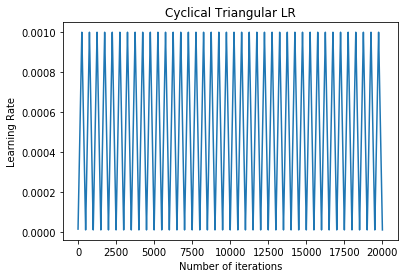

In [55]:
lrs = cyclical_tr_lr(1e-5,1e-3,channels_tensor.shape[0],1000,400,5)

Batches passed forward # - 50
Epoch: 1/400  Training Loss: 0.1429 Validation Loss: 0.1158
Batches passed forward # - 100
Epoch: 2/400  Training Loss: 0.0908 Validation Loss: 0.0734
Batches passed forward # - 150
Epoch: 3/400  Training Loss: 0.0656 Validation Loss: 0.0605
Batches passed forward # - 200
Epoch: 4/400  Training Loss: 0.0570 Validation Loss: 0.0550
Batches passed forward # - 250
Epoch: 5/400  Training Loss: 0.0525 Validation Loss: 0.0517
Batches passed forward # - 300
Epoch: 6/400  Training Loss: 0.0496 Validation Loss: 0.0494
Batches passed forward # - 350
Epoch: 7/400  Training Loss: 0.0474 Validation Loss: 0.0477
Batches passed forward # - 400
Epoch: 8/400  Training Loss: 0.0458 Validation Loss: 0.0463
Batches passed forward # - 450
Epoch: 9/400  Training Loss: 0.0444 Validation Loss: 0.0452
Batches passed forward # - 500
Epoch: 10/400  Training Loss: 0.0433 Validation Loss: 0.0443
Batches passed forward # - 550
Epoch: 11/400  Training Loss: 0.0423 Validation Loss: 0.043

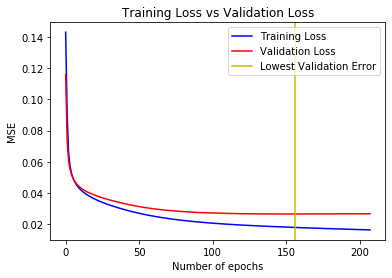

Training time - 346.9191 seconds


In [56]:
#Fixed learning rate, ReLU6

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_50_1,test_valid_50_1] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                 amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,50,50,
                                     lrs,False)

Batches passed forward # - 50
Epoch: 1/400  Training Loss: 0.1690 Validation Loss: 0.1410
Current learning rate 0.00001
Batches passed forward # - 100
Epoch: 2/400  Training Loss: 0.1076 Validation Loss: 0.0864
Current learning rate 0.00011
Batches passed forward # - 150
Epoch: 3/400  Training Loss: 0.0705 Validation Loss: 0.0613
Current learning rate 0.00021
Batches passed forward # - 200
Epoch: 4/400  Training Loss: 0.0579 Validation Loss: 0.0548
Current learning rate 0.00031
Batches passed forward # - 250
Epoch: 5/400  Training Loss: 0.0538 Validation Loss: 0.0516
Current learning rate 0.00041
Batches passed forward # - 300
Epoch: 6/400  Training Loss: 0.0511 Validation Loss: 0.0492
Current learning rate 0.00051
Batches passed forward # - 350
Epoch: 7/400  Training Loss: 0.0505 Validation Loss: 0.0475
Current learning rate 0.00061
Batches passed forward # - 400
Epoch: 8/400  Training Loss: 0.0480 Validation Loss: 0.0463
Current learning rate 0.00070
Batches passed forward # - 450
Ep

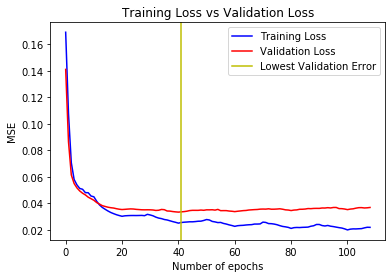

Training time - 183.6714 seconds


In [66]:
#Cyclical learning rate, ReLU6

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_50_2,test_valid_50_2] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                 amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,50,50,
                                     lrs,True)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9226713957620101
Average sum-rate (DNN) - 18.82978935949738
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 199.55688095092773


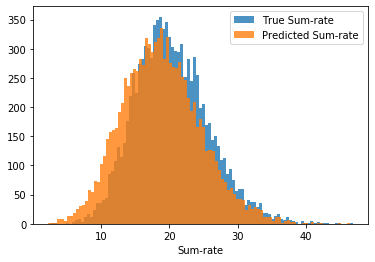

In [58]:
#sum-rate (fixed LR)

complete_test(18,10000,test_model_50_1,test_c_1,test_l_1,test_H_1_tensor,False)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.8985057648328947
Average sum-rate (DNN) - 18.336619481006892
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 203.55435037612915


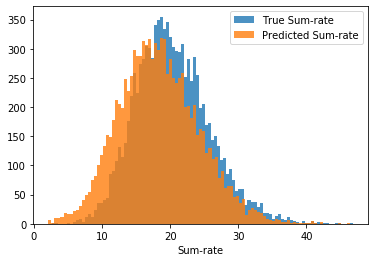

In [67]:
#sum-rate (cyclical LR)

complete_test(18,10000,test_model_50_2,test_c_1,test_l_1,test_H_1_tensor,False)

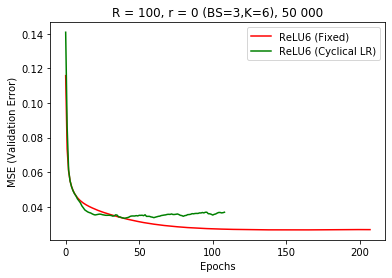

In [68]:
plt.title('R = 100, r = 0 (BS=3,K=6), 50 000')
plt.ylabel('MSE (Validation Error)')
plt.xlabel('Epochs')
plt.plot(test_valid_50_1,'red',label='Fixed')
plt.plot(test_valid_50_2,'green',label='Cyclical LR')
plt.legend(loc="upper right")
plt.show()

### <a id='100k'>Part 2.2: R = 100, r = 0, 100 000 training samples</a>

### Loading training data

In [61]:
#Load data from CSV files
channels = pd.read_csv('3_6_data/train_channels_100.csv',header=None)
labels = pd.read_csv('3_6_data/train_labels_100.csv',header=None)
valid_channels = pd.read_csv('3_6_data/valid_channels.csv',header=None)
valid_labels = pd.read_csv('3_6_data/valid_labels.csv',header=None)

#Switch colums and rows
t_channels = np.transpose(channels)
t_labels = np.transpose(labels)
t_v_channels = np.transpose(valid_channels)
t_v_labels = np.transpose(valid_labels)

#convert pandas tables to tensors
channels_tensor = torch.tensor(t_channels.values)
labels_tensor = torch.tensor(t_labels.values)
valid_c_tensor = torch.tensor(t_v_channels.values)
valid_l_tensor = torch.tensor(t_v_labels.values)

Batches passed forward # - 100
Epoch: 1/400  Training Loss: 0.1276 Validation Loss: 0.0914
Batches passed forward # - 200
Epoch: 2/400  Training Loss: 0.0686 Validation Loss: 0.0579
Batches passed forward # - 300
Epoch: 3/400  Training Loss: 0.0532 Validation Loss: 0.0505
Batches passed forward # - 400
Epoch: 4/400  Training Loss: 0.0479 Validation Loss: 0.0468
Batches passed forward # - 500
Epoch: 5/400  Training Loss: 0.0448 Validation Loss: 0.0444
Batches passed forward # - 600
Epoch: 6/400  Training Loss: 0.0426 Validation Loss: 0.0427
Batches passed forward # - 700
Epoch: 7/400  Training Loss: 0.0410 Validation Loss: 0.0413
Batches passed forward # - 800
Epoch: 8/400  Training Loss: 0.0396 Validation Loss: 0.0401
Batches passed forward # - 900
Epoch: 9/400  Training Loss: 0.0384 Validation Loss: 0.0392
Batches passed forward # - 1000
Epoch: 10/400  Training Loss: 0.0374 Validation Loss: 0.0383
Batches passed forward # - 1100
Epoch: 11/400  Training Loss: 0.0365 Validation Loss: 0.

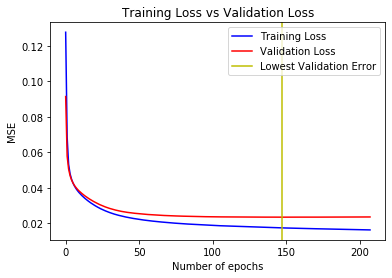

Training time - 715.3309 seconds


In [17]:
#Fixed learning rate

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_100_1,test_valid_100_1] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                   amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,100,50,
                                     lrs,False)

Training size - 100000
Training batch size - 1000
Lower bound - 0.000010
Upper bound - 0.001000
Number of iterations in each epoch - 100
Number of iterations in each step - 500
Total number of iterations - 40000


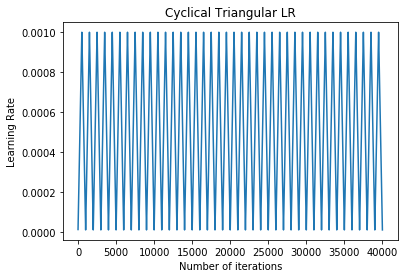

Batches passed forward # - 100
Epoch: 1/400  Training Loss: 0.1692 Validation Loss: 0.1412
Current learning rate 0.00001
Batches passed forward # - 200
Epoch: 2/400  Training Loss: 0.0735 Validation Loss: 0.0530
Current learning rate 0.00021
Batches passed forward # - 300
Epoch: 3/400  Training Loss: 0.0485 Validation Loss: 0.0442
Current learning rate 0.00041
Batches passed forward # - 400
Epoch: 4/400  Training Loss: 0.0438 Validation Loss: 0.0399
Current learning rate 0.00061
Batches passed forward # - 500
Epoch: 5/400  Training Loss: 0.0411 Validation Loss: 0.0366
Current learning rate 0.00080
Batches passed forward # - 600
Epoch: 6/400  Training Loss: 0.0379 Validation Loss: 0.0337
Current learning rate 0.00100
Batches passed forward # - 700
Epoch: 7/400  Training Loss: 0.0325 Validation Loss: 0.0312
Current learning rate 0.00080
Batches passed forward # - 800
Epoch: 8/400  Training Loss: 0.0291 Validation Loss: 0.0291
Current learning rate 0.00060
Batches passed forward # - 900
E

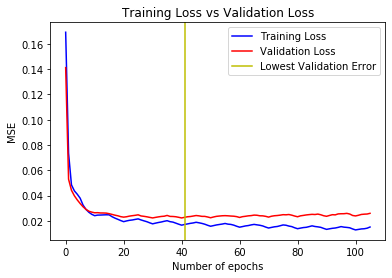

Training time - 310.8582 seconds


In [62]:
#Cyclical learning rate

lrs = cyclical_tr_lr(1e-5,1e-3,channels_tensor.shape[0],1000,400,5)

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_100_2,test_valid_100_2] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                   amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,100,50,
                                     lrs,True)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9477834535109299
Average sum-rate (DNN) - 19.342273825763048
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 268.2199282646179


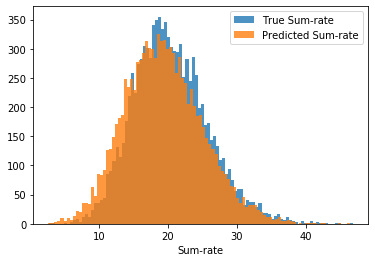

In [20]:
#sum-rate (fixed LR)

complete_test(18,10000,test_model_100_1,test_c_1,test_l_1,test_H_1_tensor,False)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9573210084544495
Average sum-rate (DNN) - 19.53691533238826
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 193.67400789260864


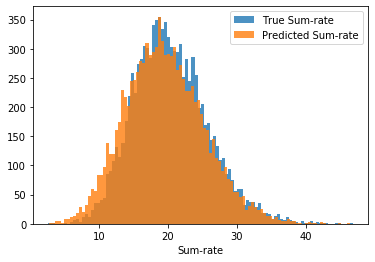

In [63]:
#sum-rate (cyclical LR)

complete_test(18,10000,test_model_100_2,test_c_1,test_l_1,test_H_1_tensor,False)

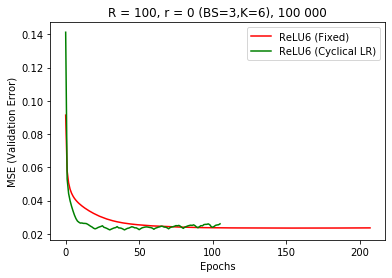

In [64]:
plt.title('R = 100, r = 0 (BS=3,K=6), 100 000')
plt.ylabel('MSE (Validation Error)')
plt.xlabel('Epochs')
plt.plot(test_valid_100_1,'red',label='Fixed')
plt.plot(test_valid_100_2,'green',label='Cyclical LR')
plt.legend(loc="upper right")
plt.show()

### <a id='200k'>Part 2.3: R = 100, r = 0, 200 000 training samples</a>

### Loading training data

In [23]:
#Load data from CSV files
channels = pd.read_csv('3_6_data/train_channels_200.csv',header=None)
labels = pd.read_csv('3_6_data/train_labels_200.csv',header=None)
valid_channels = pd.read_csv('3_6_data/valid_channels.csv',header=None)
valid_labels = pd.read_csv('3_6_data/valid_labels.csv',header=None)

#Switch colums and rows
t_channels = np.transpose(channels)
t_labels = np.transpose(labels)
t_v_channels = np.transpose(valid_channels)
t_v_labels = np.transpose(valid_labels)

#convert pandas tables to tensors
channels_tensor = torch.tensor(t_channels.values)
labels_tensor = torch.tensor(t_labels.values)
valid_c_tensor = torch.tensor(t_v_channels.values)
valid_l_tensor = torch.tensor(t_v_labels.values)

Batches passed forward # - 200
Epoch: 1/400  Training Loss: 0.1077 Validation Loss: 0.0713
Batches passed forward # - 400
Epoch: 2/400  Training Loss: 0.0540 Validation Loss: 0.0473
Batches passed forward # - 600
Epoch: 3/400  Training Loss: 0.0443 Validation Loss: 0.0420
Batches passed forward # - 800
Epoch: 4/400  Training Loss: 0.0402 Validation Loss: 0.0390
Batches passed forward # - 1000
Epoch: 5/400  Training Loss: 0.0375 Validation Loss: 0.0369
Batches passed forward # - 1200
Epoch: 6/400  Training Loss: 0.0355 Validation Loss: 0.0352
Batches passed forward # - 1400
Epoch: 7/400  Training Loss: 0.0339 Validation Loss: 0.0339
Batches passed forward # - 1600
Epoch: 8/400  Training Loss: 0.0324 Validation Loss: 0.0326
Batches passed forward # - 1800
Epoch: 9/400  Training Loss: 0.0312 Validation Loss: 0.0315
Batches passed forward # - 2000
Epoch: 10/400  Training Loss: 0.0301 Validation Loss: 0.0306
Batches passed forward # - 2200
Epoch: 11/400  Training Loss: 0.0291 Validation Los

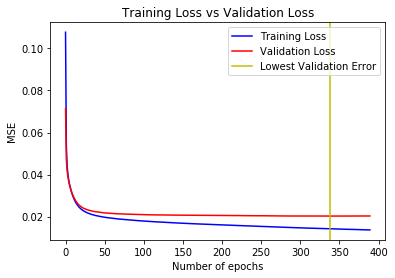

Training time - 2515.3031 seconds


In [24]:
#Fixed learning rate

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_200_1,test_valid_200_1] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                   amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,200,50,
                                     lrs,False)

Training size - 200000
Training batch size - 1000
Lower bound - 0.000010
Upper bound - 0.001000
Number of iterations in each epoch - 200
Number of iterations in each step - 1000
Total number of iterations - 80000


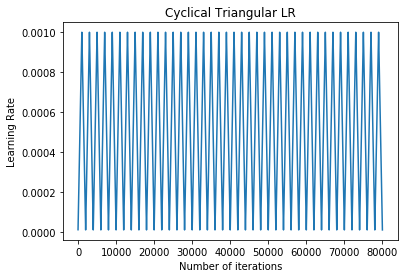

Batches passed forward # - 200
Epoch: 1/400  Training Loss: 0.1576 Validation Loss: 0.1396
Current learning rate 0.00001
Batches passed forward # - 400
Epoch: 2/400  Training Loss: 0.0662 Validation Loss: 0.0518
Current learning rate 0.00021
Batches passed forward # - 600
Epoch: 3/400  Training Loss: 0.0487 Validation Loss: 0.0456
Current learning rate 0.00041
Batches passed forward # - 800
Epoch: 4/400  Training Loss: 0.0437 Validation Loss: 0.0408
Current learning rate 0.00060
Batches passed forward # - 1000
Epoch: 5/400  Training Loss: 0.0396 Validation Loss: 0.0366
Current learning rate 0.00080
Batches passed forward # - 1200
Epoch: 6/400  Training Loss: 0.0303 Validation Loss: 0.0269
Current learning rate 0.00100
Batches passed forward # - 1400
Epoch: 7/400  Training Loss: 0.0253 Validation Loss: 0.0248
Current learning rate 0.00080
Batches passed forward # - 1600
Epoch: 8/400  Training Loss: 0.0235 Validation Loss: 0.0238
Current learning rate 0.00060
Batches passed forward # - 1

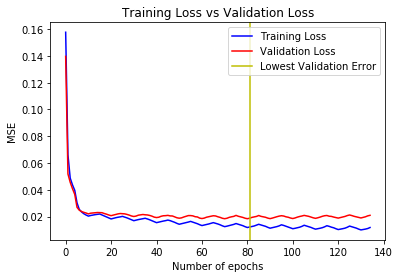

Training time - 816.4779 seconds


In [25]:
#Cyclical learning rate

lrs = cyclical_tr_lr(1e-5,1e-3,channels_tensor.shape[0],1000,400,5)

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_200_2,test_valid_200_2] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                   amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,200,50,
                                     lrs,True)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9670183300029774
Average sum-rate (DNN) - 19.734817340566693
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 257.36755084991455


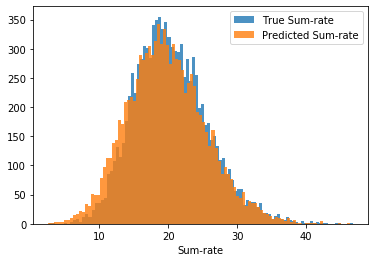

In [26]:
#sum-rate (fixed LR)

complete_test(18,10000,test_model_200_1,test_c_1,test_l_1,test_H_1_tensor,False)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9682045342472626
Average sum-rate (DNN) - 19.759025283025757
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 270.21998476982117


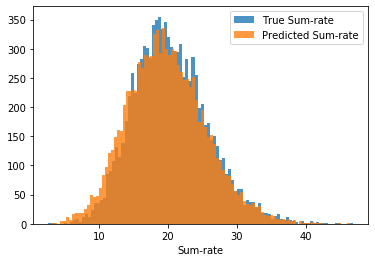

In [27]:
#sum-rate (cyclical LR)

complete_test(18,10000,test_model_200_2,test_c_1,test_l_1,test_H_1_tensor,False)

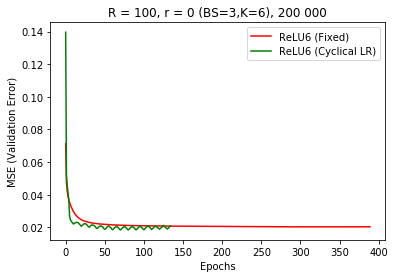

In [28]:
plt.title('R = 100, r = 0 (BS=3,K=6), 200 000')
plt.ylabel('MSE (Validation Error)')
plt.xlabel('Epochs')
plt.plot(test_valid_200_1,'red',label='Fixed')
plt.plot(test_valid_200_2,'green',label='Cyclical LR')
plt.legend(loc="upper right")
plt.show()

### <a id='500k'>Part 2.4: R = 100, r = 0, 500 000 training samples</a>

### Loading training data

In [29]:
#Load data from CSV files
channels = pd.read_csv('3_6_data/train_channels_500.csv',header=None)
labels = pd.read_csv('3_6_data/train_labels_500.csv',header=None)
valid_channels = pd.read_csv('3_6_data/valid_channels.csv',header=None)
valid_labels = pd.read_csv('3_6_data/valid_labels.csv',header=None)

#Switch colums and rows
t_channels = np.transpose(channels)
t_labels = np.transpose(labels)
t_v_channels = np.transpose(valid_channels)
t_v_labels = np.transpose(valid_labels)

#convert pandas tables to tensors
channels_tensor = torch.tensor(t_channels.values)
labels_tensor = torch.tensor(t_labels.values)
valid_c_tensor = torch.tensor(t_v_channels.values)
valid_l_tensor = torch.tensor(t_v_labels.values)

Batches passed forward # - 500
Epoch: 1/400  Training Loss: 0.0889 Validation Loss: 0.0583
Batches passed forward # - 1000
Epoch: 2/400  Training Loss: 0.0431 Validation Loss: 0.0371
Batches passed forward # - 1500
Epoch: 3/400  Training Loss: 0.0341 Validation Loss: 0.0320
Batches passed forward # - 2000
Epoch: 4/400  Training Loss: 0.0302 Validation Loss: 0.0291
Batches passed forward # - 2500
Epoch: 5/400  Training Loss: 0.0277 Validation Loss: 0.0272
Batches passed forward # - 3000
Epoch: 6/400  Training Loss: 0.0261 Validation Loss: 0.0259
Batches passed forward # - 3500
Epoch: 7/400  Training Loss: 0.0249 Validation Loss: 0.0249
Batches passed forward # - 4000
Epoch: 8/400  Training Loss: 0.0241 Validation Loss: 0.0242
Batches passed forward # - 4500
Epoch: 9/400  Training Loss: 0.0234 Validation Loss: 0.0237
Batches passed forward # - 5000
Epoch: 10/400  Training Loss: 0.0229 Validation Loss: 0.0232
Batches passed forward # - 5500
Epoch: 11/400  Training Loss: 0.0224 Validation 

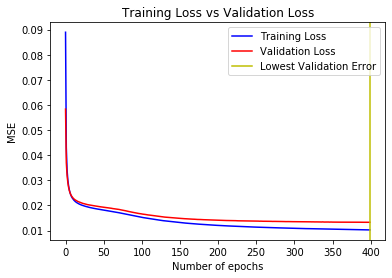

Training time - 5575.538 seconds


In [30]:
#Fixed learning rate

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_200_1,test_valid_200_1] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                   amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,500,50,
                                     lrs,False)

Training size - 500000
Training batch size - 1000
Lower bound - 0.000010
Upper bound - 0.001000
Number of iterations in each epoch - 500
Number of iterations in each step - 2500
Total number of iterations - 200000


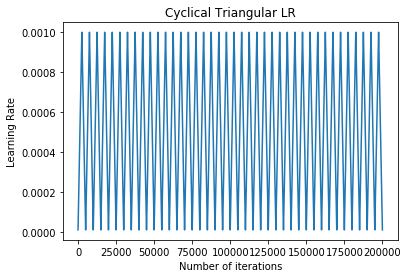

Batches passed forward # - 500
Epoch: 1/400  Training Loss: 0.1360 Validation Loss: 0.1045
Current learning rate 0.00001
Batches passed forward # - 1000
Epoch: 2/400  Training Loss: 0.0466 Validation Loss: 0.0375
Current learning rate 0.00021
Batches passed forward # - 1500
Epoch: 3/400  Training Loss: 0.0330 Validation Loss: 0.0290
Current learning rate 0.00041
Batches passed forward # - 2000
Epoch: 4/400  Training Loss: 0.0267 Validation Loss: 0.0246
Current learning rate 0.00060
Batches passed forward # - 2500
Epoch: 5/400  Training Loss: 0.0242 Validation Loss: 0.0230
Current learning rate 0.00080
Batches passed forward # - 3000
Epoch: 6/400  Training Loss: 0.0230 Validation Loss: 0.0225
Current learning rate 0.00100
Batches passed forward # - 3500
Epoch: 7/400  Training Loss: 0.0214 Validation Loss: 0.0212
Current learning rate 0.00080
Batches passed forward # - 4000
Epoch: 8/400  Training Loss: 0.0202 Validation Loss: 0.0203
Current learning rate 0.00060
Batches passed forward # 

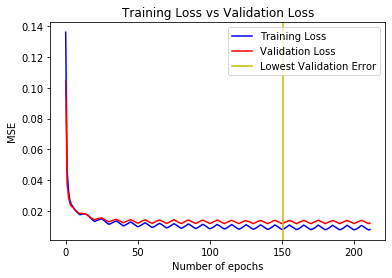

Training time - 2777.135 seconds


In [31]:
#Cyclical learning rate

lrs = cyclical_tr_lr(1e-5,1e-3,channels_tensor.shape[0],1000,400,5)

model = initiate_model(54,200,18,0.2,0.2,F.relu6,False,0)
[test_model_200_2,test_valid_200_2] = train_nn(model,nn.MSELoss(),torch.optim.AdamW(model.parameters(),lr=0.0001,
                                                                          weight_decay=0.05,
                                                                                   amsgrad=True),channels_tensor,
        labels_tensor,valid_c_tensor,valid_l_tensor,1000,1000,400,500,50,
                                     lrs,True)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9660248717686865
Average sum-rate (DNN) - 19.71454294019503
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 209.66413235664368


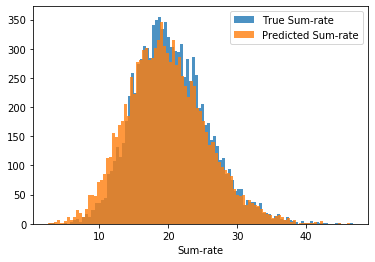

In [34]:
#sum-rate (fixed LR)

complete_test(18,10000,test_model_500_1,test_c_1,test_l_1,test_H_1_tensor,False)

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9716284250304679
Average sum-rate (DNN) - 19.828899717774473
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 202.63917207717896


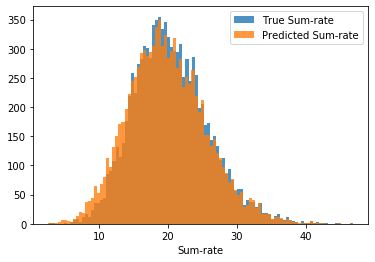

In [35]:
#sum-rate (cyclical LR)

complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,False)

### Binarised

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9834226771408238
Average sum-rate (DNN) - 20.069595683760713
Average sum-rate (WMMSE) - 20.40790409888707
Testing time - 223.17122864723206


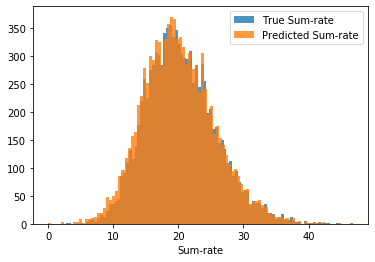

In [36]:
complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,True)

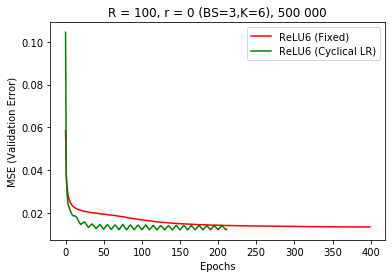

In [40]:
plt.title('R = 100, r = 0 (BS=3,K=6), 500 000')
plt.ylabel('MSE (Validation Error)')
plt.xlabel('Epochs')
plt.plot(test_valid_500_1,'red',label='Fixed')
plt.plot(test_valid_500_2,'green',label='Cyclical LR')
plt.legend(loc="upper right")
plt.show()

## <a id='part_3'> Part 3: Testing </a>

### <a id='r'>Part 3.1: Testing for other r: R = 100, r = {20,50,99}</a>

### Part 3.1.1: R = 100, r = 20

In [41]:
#import R = 100, r = 20 testing data
test_channels_1 = pd.read_csv('3_6_data/test/test_channels_100_20.csv',header=None)
test_labels_1 = pd.read_csv('3_6_data/test/test_labels_100_20.csv',header=None)
test_H_1 = pd.read_csv('3_6_data/test/test_H_100_20.csv',header=None)

t_t_channels_1 = np.transpose(test_channels_1)
t_t_labels_1 = np.transpose(test_labels_1)
t_H_1 = np.transpose(test_H_1)

test_c_1 = torch.tensor(t_t_channels_1.values)
test_l_1 = torch.tensor(t_t_labels_1.values)
test_H_1_tensor = torch.tensor(t_H_1.values)

### Binarised

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9845263382927176
Average sum-rate (DNN) - 16.371725542222013
Average sum-rate (WMMSE) - 16.629037645262468
Testing time - 217.33976697921753


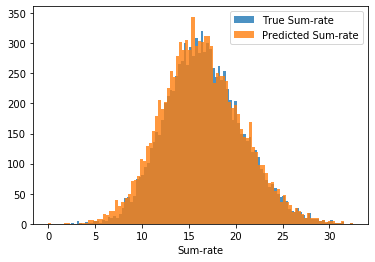

In [42]:
complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,True)

### Part 3.1.2: R = 100, r = 50

In [43]:
#import R = 100, r = 50 testing data
test_channels_1 = pd.read_csv('3_6_data/test/test_channels_100_50.csv',header=None)
test_labels_1 = pd.read_csv('3_6_data/test/test_labels_100_50.csv',header=None)
test_H_1 = pd.read_csv('3_6_data/test/test_H_100_50.csv',header=None)

t_t_channels_1 = np.transpose(test_channels_1)
t_t_labels_1 = np.transpose(test_labels_1)
t_H_1 = np.transpose(test_H_1)

test_c_1 = torch.tensor(t_t_channels_1.values)
test_l_1 = torch.tensor(t_t_labels_1.values)
test_H_1_tensor = torch.tensor(t_H_1.values)

### Binarised

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9837025779576253
Average sum-rate (DNN) - 13.80605320682527
Average sum-rate (WMMSE) - 14.034784005028795
Testing time - 217.5691545009613


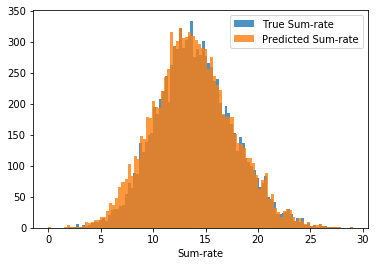

In [44]:
complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,True)

### Part 3.1.3: R = 100, r = 99

In [45]:
#import R = 100, r = 99 testing data
test_channels_1 = pd.read_csv('3_6_data/test/test_channels_100_99.csv',header=None)
test_labels_1 = pd.read_csv('3_6_data/test/test_labels_100_99.csv',header=None)
test_H_1 = pd.read_csv('3_6_data/test/test_H_100_99.csv',header=None)

t_t_channels_1 = np.transpose(test_channels_1)
t_t_labels_1 = np.transpose(test_labels_1)
t_H_1 = np.transpose(test_H_1)

test_c_1 = torch.tensor(t_t_channels_1.values)
test_l_1 = torch.tensor(t_t_labels_1.values)
test_H_1_tensor = torch.tensor(t_H_1.values)

### Binarised

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9822686176069969
Average sum-rate (DNN) - 11.525430651750314
Average sum-rate (WMMSE) - 11.733481499010496
Testing time - 195.44399166107178


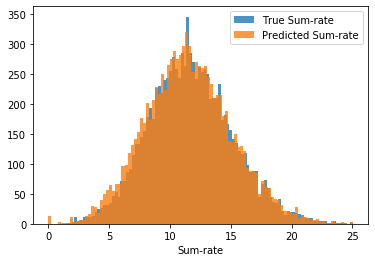

In [46]:
complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,True)

### <a id = 'R'>Part 3.2: Testing for other r: R = {200, 300, 500}, r = 0</a>

### Part 3.2.1: R = 200, r = 0

In [47]:
#import R = 200, r = 0 testing data
test_channels_1 = pd.read_csv('3_6_data/test/test_channels_200.csv',header=None)
test_labels_1 = pd.read_csv('3_6_data/test/test_labels_200.csv',header=None)
test_H_1 = pd.read_csv('3_6_data/test/test_H_200.csv',header=None)

t_t_channels_1 = np.transpose(test_channels_1)
t_t_labels_1 = np.transpose(test_labels_1)
t_H_1 = np.transpose(test_H_1)

test_c_1 = torch.tensor(t_t_channels_1.values)
test_l_1 = torch.tensor(t_t_labels_1.values)
test_H_1_tensor = torch.tensor(t_H_1.values)

### Binarised

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9951443564142327
Average sum-rate (DNN) - 15.393926105727232
Average sum-rate (WMMSE) - 15.469038242045208
Testing time - 207.52540826797485


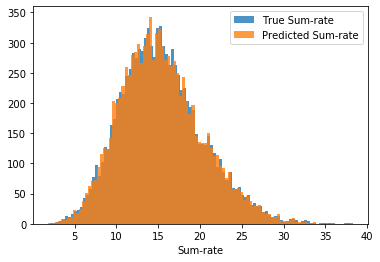

In [48]:
complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,True)

### Part 3.2.2: R = 300, r = 0

In [49]:
#import R = 300, r = 0 testing data
test_channels_1 = pd.read_csv('3_6_data/test/test_channels_300.csv',header=None)
test_labels_1 = pd.read_csv('3_6_data/test/test_labels_300.csv',header=None)
test_H_1 = pd.read_csv('3_6_data/test/test_H_300.csv',header=None)

t_t_channels_1 = np.transpose(test_channels_1)
t_t_labels_1 = np.transpose(test_labels_1)
t_H_1 = np.transpose(test_H_1)

test_c_1 = torch.tensor(t_t_channels_1.values)
test_l_1 = torch.tensor(t_t_labels_1.values)
test_H_1_tensor = torch.tensor(t_H_1.values)

### Binarised

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9958796021986903
Average sum-rate (DNN) - 11.82736478268595
Average sum-rate (WMMSE) - 11.876299862527201
Testing time - 198.39248943328857


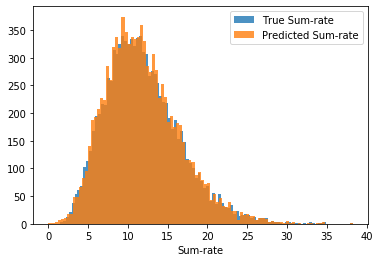

In [50]:
complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,True)

### Part 3.2.3: R = 500, r = 0

In [51]:
#import R = 500, r = 0 testing data
test_channels_1 = pd.read_csv('3_6_data/test/test_channels_500.csv',header=None)
test_labels_1 = pd.read_csv('3_6_data/test/test_labels_500.csv',header=None)
test_H_1 = pd.read_csv('3_6_data/test/test_H_500.csv',header=None)

t_t_channels_1 = np.transpose(test_channels_1)
t_t_labels_1 = np.transpose(test_labels_1)
t_H_1 = np.transpose(test_H_1)

test_c_1 = torch.tensor(t_t_channels_1.values)
test_l_1 = torch.tensor(t_t_labels_1.values)
test_H_1_tensor = torch.tensor(t_H_1.values)

### Binarised

0 iterations passed
1000 iterations passed
2000 iterations passed
3000 iterations passed
4000 iterations passed
5000 iterations passed
6000 iterations passed
7000 iterations passed
8000 iterations passed
9000 iterations passed
Sum-rate approximation accuracy - 0.9884656229036164
Average sum-rate (DNN) - 7.215551643368968
Average sum-rate (WMMSE) - 7.299749709224379
Testing time - 198.31370162963867


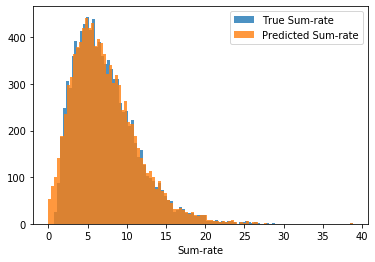

In [52]:
complete_test(18,10000,test_model_500_2,test_c_1,test_l_1,test_H_1_tensor,True)